In [1]:
from IPython.display import HTML
HTML(open('stylesheet.css').read())

 The optimization package of Qiskit is mainly for QUBO, or general quadratic problems. However, as we are dealing with max-4-cut, we have terms upto order 4. It seems that we need to implement the QAOA algorithm on a circuit level, unless there are other packages unknown to us.

Please put reusable functions into python files and keep the minimum amount of code in this notebook. <br>
Thanks to Jakob and Franziska, now we have a sample data to work on with. I (Kevin) suggest that we follow a similar structure as 'https://qiskit.org/textbook/ch-applications/qaoa.html'. 
1. Use brute force to compute the costs for all combinations and find the optimal cost. This will be used for   scoring the performance of our QAOA implementation.
2. Construct the mixing hamiltonian and problem Hamiltonian gate by gate and draw out the circuit diagrams. (For this refer to Jezer's document)
3. Assemble the circuit and draw the circuit diagram
4. Run classical optimization. (I think Qiskit has a few built-in classical optimizers that we can use.)
5. Evaluate the results, and check the performance for different problem sizes and circuit depth.

## Problem 1: Minimizing the total weighted charging time
<div class = "Prob"> 
We're given $n$ vehicles that need to be charged. Some vehicles are more important than others (ambulances for example) and so each vehicle is assigned a 'weight' $w_i$ accordingly. Each vehicle also has a charging time $t_i$. Now, given $k$ charging ports, the question is this: Which charging port should each vehicle ideally be directed to and in what order?

So there are two sub-questions here. The arguably easier problem is "Given a group of vehicles in a queue waiting on a single charging port, what order should they be in?". Larger weights and shorter charging times should be given preference. So a fair solution is to arrange the vehicles in decreasing order of $\frac{w_i}{t_i}$.

The harder problem that comes before this one is "How would you distribute vehicles to different charging ports in the first place?"
To deal with this problem, we first construct a weighted complete graph where each node represents a vehicle. The weight of the edge connecting nodes $i$ and $j$ is $\min \{w_i t_j, w_j t_i\}$. This weight is the 'cost' incurred if the vehicles represented by these nodes were sent to the same charging port. $w_i t_j$ is the price $i$ pays if it has to wait for $j$, and $w_j t_i$ is the price $j$ pays if it has to wait for $i$. We know we can pick the minimum because we've already solved the problem of ordering in the previous question.

In terms of this graph then, the question becomes "How can we divide this graph into $k$ connected graphs such that the weights of the edges that remain are minimized?", or "How can we divide this graph into $k$ connected graphs such that the weights of the edges that we remove are maximized?". This is the Max-k-cut problem, and it can be solved using QAOA.

## Encoding qubits

To simplify things we constrain our problem such that $k$ is a power of $2$. Let's say $k=2^l$.
We arrange our qubits into $n$ registers where $n$ is the number of vehicles. Each register has $l$ qubits. By the end of the algorithm, the output we read from a register should be the binary representation of the charging port that that register’s corresponding vehicle should go to.

## Constructing the Mixer Hamiltonian

<div class = "Ex">  <br>
For the mixer hamiltonian $H_M$, we pick $\sum\limits_{i=1}^{n}{X}$.

The unitary operation for $e^{-i H_M \beta}$ is then implemented by applying $R_X(2\beta)$ gates on every qubit.
The initial state for this mixer is one where every qubit is in the plus state so we start by applying $H$ gates on every qubit.

## Constructing the Cost Hamiltonian

For the cost hamiltonian,

$H_C=\sum\limits_{1<=u<v<=N}w_{uv}\prod\limits_{j=0}^l\frac{1+Z_{u_j}Z_{v_j}}{2}$

We need to implement the operation $e^{-iH_C \gamma}$.

Since $H_C$ is a diagonal matrix, exponentiation is simple and we can exponentiate terms in this summation individually and multiply them together. Each term in the summation in the $H_C$ expression contains a product of matrices, and each term in the expansion of this product is a tensor product of $Z$ gates and Identity gates. This will always be a diagonal matrix with each entry either being +1 or -1. For each term in the expansion of this product then, we replace +1 entries with $e^{\frac{-i\gamma w}{2^l}}$ and -1 terms with $e^{\frac{i\gamma w}{2^l}}$.
Now we need a rule about which entry in the original matrix is +1 and which entry is -1. It can be worked out that the entry on the i-th row/column of this matrix is -1 if the digits of the bitstring representing i add up to an odd number (that is, they ‘bitwise add up’ to 1) and it’s +1 otherwise. So if the matrix is $U=Z_{u_0}\otimes Z_{v_0}\otimes Z_{u_1}\otimes Z_{v_1}$, then $e^{U}|u_0,v_0,u_1,v_1\rangle = (-1)^{u_0⊕v_0⊕u_1⊕v_1}|u_0,v_0,u_1,v_1\rangle$.

So, what we can do is we can first draw a chain of $CNOT$s from each qubit that’s involved with a $Z$ gate to the next one. This should take $|u_0,v_0,u_1,v_1\rangle$ to $|u_0, (u_0⊕v_0), (u_0⊕v_0⊕u_1), (u_0⊕v_0⊕u_1⊕v_1)\rangle$
Applying an $R_Z(w_{uv}\gamma/2^{l-1})$ to the last qubit leads to a phase of $e^{\frac{-i\gamma w_{uv}}{2^l}}$ if $u_0⊕v_0⊕u_1⊕v_1=0$ and it leads to a phase of $e^{\frac{-i\gamma w_{uv}}{2^l}}$ otherwise. This is exactly what we needed. All we need to do is undo the $CNOT$s by applying them in reverse order.

This then is what we do for each term in the summation of $H_C$.

In [10]:
from data_processing import *
from Max_k_cut_functions import *
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize

ModuleNotFoundError: No module named 'data_processing'

In [2]:
# Set parameters here

p = 3  # the depth of QAOA

l = 2  # the number of qubits for each node, k = 2^l where k is the number of subgraphs we'd like to cut, 
       # or to say, the k in 'max-k-cut'. l = 2 for a max-4-cut example 
    
n_imp = 3  # the number of important nodes, or to say the nodes with which the associated edges have larger weights

n_unimp = 2  # the number of less important nodes ... smaller weights

nshots = 512  # the number of shots per iteration

init_params = [np.pi/8, np.pi]*p  # the initial parameters gammas and betas. This is however unused in the full
                                  # optimization loop since the educated global guess optimization does not require
                                  # initial guesses. The init_params here will be used later to demonstrate the 
                                  # performance of a local optimzation alone.

local_optimization_method = 'Powell'  # the local optimization algorithm to be used, supported by Scipy. 
                                      # good candidates include 'Powell', 'COBYLA', 'Nelder-Mead', 'BFGS'
    
###################################################################################################################

k = 2**l  # see above
n = n_imp + n_unimp  # total number of nodes

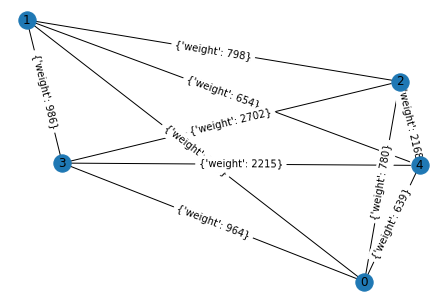

In [3]:
# Generate sample data

G = generate_data(n_unimp, n_imp)
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True)
nx.draw_networkx_edge_labels(G, pos)
plt.show()

In [4]:
# Get a matrix representation of the problem and use Brute force to obtain the optimal solution

weights = get_weight_matrix(G)  # Obtain the weight matrix

R = compute_normalization_scale(weights)  # The normalization scale suggested by the paper

rescaled_weights = weights / R  # The rescaled weight matrix

cost_of_graph, partition = brut_force(G,k)  # Uses brute force to find the optimal solution, so that we have a reference 
                                   # to test our algorithm
    
normalized_cost = cost_of_graph / R


print('original weight matrix =', weights)
print('normalization factor =', R)
print('rescaled weight matrix =', rescaled_weights)
print('original cost =', cost_of_graph)
print('normalized cost =', normalized_cost)

original weight matrix = [[   0  320  780  964  639]
 [ 320    0  798  986  654]
 [ 780  798    0 2702 2168]
 [ 964  986 2702    0 2215]
 [ 639  654 2168 2215    0]]
normalization factor = 16887.5
rescaled weight matrix = [[0.         0.01894893 0.04618801 0.05708364 0.03783864]
 [0.01894893 0.         0.04725389 0.05838638 0.03872687]
 [0.04618801 0.04725389 0.         0.16       0.12837898]
 [0.05708364 0.05838638 0.16       0.         0.1311621 ]
 [0.03783864 0.03872687 0.12837898 0.1311621  0.        ]]
original cost = 11906
normalized cost = 0.705018504811251


In [5]:
param_history, cost_history, circ_history = full_optimization_loop(n, l, rescaled_weights, p, 
                                                                   local_optimization_method=local_optimization_method, 
                                                                   optimal_cost=normalized_cost)

1st params [2.95086599 7.15996707]
1st cost 0.6002648501110331
2nd iteration (EGG), params [ 2.95086599 -0.122103    7.15996707 10.3751872 ]
2nd iteration (EGG),  cost 0.6090103395632901
2nd iteration (Nelder-Mead), params [ 2.95085482 -0.12515507  7.15978099 10.3754388 ]
2nd iteration (Nelder-Mead), cost 0.6145622455588484
3th iteration (EGG), params [ 2.95085482e+00 -1.25155070e-01 -4.48180656e-03  7.15978099e+00
  1.03754388e+01  2.27262413e+00]
3th iteration (EGG),  cost 0.612276785714289
3th iteration (Nelder-Mead), params [ 2.95085482e+00 -1.25155070e-01 -4.59385172e-03  7.15978099e+00
  1.03754388e+01  2.32943974e+00]
3th iteration (Nelder-Mead), cost 0.6146348769430084
Approximation Ratio Evolution  [0.85141716 0.86382178 0.87169662 0.86845492 0.87179964]


In [6]:
param_history

[array([2.95086599, 7.15996707]),
 array([ 2.95086599, -0.122103  ,  7.15996707, 10.3751872 ]),
 array([ 2.95085482, -0.12515507,  7.15978099, 10.3754388 ]),
 array([ 2.95085482e+00, -1.25155070e-01, -4.48180656e-03,  7.15978099e+00,
         1.03754388e+01,  2.27262413e+00]),
 array([ 2.95085482e+00, -1.25155070e-01, -4.59385172e-03,  7.15978099e+00,
         1.03754388e+01,  2.32943974e+00])]

In [7]:
cost_history

[0.6002648501110331,
 0.6090103395632901,
 0.6145622455588484,
 0.612276785714289,
 0.6146348769430084]

In [8]:
#circ_history[-1].decompose().draw()

In [9]:
circ = make_full_circuit(n,l,rescaled_weights,p)  # building the full circuit
counts, transpiled_circ = run_circuit(circ, param_history[-1], nshots=nshots)  # do a final run with optimal parameters found
show_distribution(counts, l)

{'[[0, 4], [1], [2], [3]]': 56,
 '[[0, 4], [1, 2, 3]]': 4,
 '[[0, 4], [1], [2, 3]]': 13,
 '[[0, 1, 2], [3], [4]]': 8,
 '[[0], [1, 4], [2], [3]]': 40,
 '[[0, 3], [1, 4], [2]]': 11,
 '[[0, 4], [1, 2], [3]]': 4,
 '[[0], [1, 3], [2], [4]]': 34,
 '[[0], [1], [2, 3], [4]]': 47,
 '[[0, 1], [2], [3], [4]]': 8,
 '[[0], [1, 4], [2, 3]]': 13,
 '[[0, 3, 4], [1], [2]]': 13,
 '[[0, 2, 3], [1], [4]]': 1,
 '[[0, 3], [1], [2], [4]]': 45,
 '[[0, 1, 3], [2], [4]]': 3,
 '[[0], [1], [2, 3, 4]]': 11,
 '[[0, 4], [1, 3], [2]]': 7,
 '[[0, 1, 2, 4], [3]]': 2,
 '[[0, 3], [1], [2, 4]]': 12,
 '[[0], [1, 2, 4], [3]]': 1,
 '[[0, 1, 4], [2, 3]]': 2,
 '[[0], [1], [2, 4], [3]]': 54,
 '[[0, 2], [1, 3, 4]]': 3,
 '[[0], [1, 3], [2, 4]]': 8,
 '[[0, 1], [2, 4], [3]]': 3,
 '[[0], [1], [2], [3, 4]]': 78,
 '[[0, 3], [1, 2], [4]]': 2,
 '[[0], [1, 3, 4], [2]]': 3,
 '[[0, 2], [1], [3, 4]]': 5,
 '[[0], [1, 2, 3], [4]]': 3,
 '[[0, 1], [2], [3, 4]]': 2,
 '[[0], [1, 2], [3], [4]]': 1,
 '[[0, 3, 4], [1, 2]]': 2,
 '[[0, 1], [2, 3, 4]]'

## Algorithm broke into parts

### Build the circuit

In [10]:
mb = make_mixing_block(n,l,1)  # building the mixing block
#mb.draw()

In [11]:
cb = make_cost_block(n,l,rescaled_weights,1)  # building the cost block 
#cb.draw()

In [12]:
ib = make_initial_block(n,l)  # building the initialization block
#ib.draw()

In [13]:
circ = make_full_circuit(n,l,rescaled_weights,p)  # building the full circuit
#circ.decompose().draw()

### Run a sample circuit

In [14]:
counts, transpiled_circ = run_circuit(circ, init_params, nshots=nshots)  # visualize the circuit to be runned
transpiled_circ.decompose().draw()

global phase: -3.6248
         ┌─────────┐                                                        »
    q_0: ┤ U2(0,π) ├──■───────────────────────────────────■─────────■───────»
         ├─────────┤  │                                   │       ┌─┴─┐     »
    q_1: ┤ U2(0,π) ├──┼────■──────────────────────────────┼────■──┤ X ├──■──»
         ├─────────┤┌─┴─┐  │  ┌────────────────────────┐┌─┴─┐  │  └───┘┌─┴─┐»
    q_2: ┤ U2(0,π) ├┤ X ├──┼──┤ U1(0.0297649044899699) ├┤ X ├──┼───────┤ X ├»
         ├─────────┤└───┘┌─┴─┐├────────────────────────┤└───┘┌─┴─┐     └───┘»
    q_3: ┤ U2(0,π) ├─────┤ X ├┤ U1(0.0297649044899699) ├─────┤ X ├──────────»
         ├─────────┤     └───┘└────────────────────────┘     └───┘          »
    q_4: ┤ U2(0,π) ├────────────────────────────────────────────────────────»
         ├─────────┤                                                        »
    q_5: ┤ U2(0,π) ├────────────────────────────────────────────────────────»
         ├─────────┤                                                        »
    q_6: ┤ U2(0,π) ├────────────────────────────────────────────────────────»
         ├─────────┤                                                        »
    q_7: ┤ U2(0,π) ├────────────────────────────────────────────────────────»
         ├─────────┤                                                        »
    q_8: ┤ U2(0,π) ├────────────────────────────────────────────────────────»
         ├─────────┤                                                        »
    q_9: ┤ U2(0,π) ├────────────────────────────────────────────────────────»
         └─────────┘                                                        »
meas: 10/═══════════════════════════════════════════════════════════════════»
                                                                            »
«                                                                 »
«    q_0: ───────────────────────────────────────────■────■───────»
«                                                  ┌─┴─┐  │       »
«    q_1: ──────────────────────────────────────■──┤ X ├──┼────■──»
«                                             ┌─┴─┐└───┘  │    │  »
«    q_2: ──■──────────────────────────────■──┤ X ├───────┼────┼──»
«         ┌─┴─┐┌────────────────────────┐┌─┴─┐└───┘       │    │  »
«    q_3: ┤ X ├┤ U1(0.0297649044899699) ├┤ X ├────────────┼────┼──»
«         └───┘└────────────────────────┘└───┘          ┌─┴─┐  │  »
«    q_4: ──────────────────────────────────────────────┤ X ├──┼──»
«                                                       └───┘┌─┴─┐»
«    q_5: ───────────────────────────────────────────────────┤ X ├»
«                                                            └───┘»
«    q_6: ────────────────────────────────────────────────────────»
«                                                                 »
«    q_7: ────────────────────────────────────────────────────────»
«                                                                 »
«    q_8: ────────────────────────────────────────────────────────»
«                                                                 »
«    q_9: ────────────────────────────────────────────────────────»
«                                                                 »
«meas: 10/════════════════════════════════════════════════════════»
«                                                                 »
«                                                            »
«    q_0: ────────────────────────────■─────────■────────────»
«                                     │       ┌─┴─┐          »
«    q_1: ────────────────────────────┼────■──┤ X ├──■───────»
«                                     │    │  └───┘  │       »
«    q_2: ────────────────────────────┼────┼─────────┼───────»
«                                     │    │         │       »
«    q_3: ────────────────────────────┼────┼─────────┼───────»
«         ┌────────────────────────┐┌─┴─┐  │       ┌─┴─┐     »
«    q_4: ┤ U1(0.0725519546943017) ├┤ X ├──┼───────┤ 

In [15]:
average_cost = compute_cost(counts, l, rescaled_weights, n_counts = nshots)  # compute the cost from the sample run 
                                                                             # above
average_cost

0.4579745327535177

### Run QAOA with only a local optimization algorithm 

In [16]:
func_to_optimize = func_to_optimize_wrapper(circ, l, rescaled_weights, nshots=512, simulator='aer_simulator')

In [17]:
res = minimize(func_to_optimize, init_params, method=local_optimization_method)
print('cost', -1*res.fun)
print('approximation_ratio', -1*res.fun / normalized_cost)
print('parameters', res.x)

cost 0.5600743662102184
approximation_ratio 0.7944108734566658
parameters [0.45028387 3.71834811 0.38853789 2.78000812 0.36293913 3.05694757]


# Benchmarking

In [18]:
distribution_qaoa = show_distribution(counts, l)

In [19]:
counts_accept=nshots*0.05
len_d = len(distribution_qaoa.values())

In [20]:
Prob_distribution = dict()
for key, value in distribution_qaoa.items():
    if value > counts_accept:
        Prob_distribution[key]=value

In [21]:
import ast

In [22]:
for key, value in Prob_distribution.items():
    P = {}
    participation_data = ast.literal_eval(key)  
    for i in range(len(participation_data)):
        P["P"+str(i)] = participation_data[i]
    a,b = cost(G, P)

# Key muss array sein, kein string

TypeError: cannot unpack non-iterable numpy.int32 object

In [ ]:

print(partition)